In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.losses import MeanSquaredError
import pickle
import json
import matplotlib.pyplot as plt


In [2]:
# Load the training data
df = pd.read_csv("train_data.csv")

# Drop unnecessary columns
df_numeric = df.select_dtypes(exclude=['object'])
column_to_drop = 'datasetId'
df.drop(column_to_drop, axis=1, inplace=True)

In [3]:
# Calculate the correlation matrix
correlation_matrix = df_numeric.corr()

In [4]:
# Select the target variable 'HR'
target_column = 'HR'

# Specify the columns to scale
columns_to_scale = ['MEAN_RR', 'MEDIAN_RR', 'LF_NU', 'HF_NU', 'HF_LF', 'SDRR_RMSSD_REL_RR', 'HF_PCT', 'HF', 'SDSD_REL_RR', 'RMSSD_REL_RR', 'higuci', 'LF_HF', 'VLF', 'TP', 'sampen', 'SKEW', 'SKEW_REL_RR']

# Standard Scaling
standard_scaler = MinMaxScaler()
df_numeric[columns_to_scale] = standard_scaler.fit_transform(df_numeric[columns_to_scale])


In [5]:
# Specify features (X) and target variable (y)
X = df_numeric[columns_to_scale]
y = df_numeric['HR']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss=MeanSquaredError())

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=5, verbose=1, validation_data=(X_test, y_test))


Epoch 1/50
800/800 [==============================] - 7s 6ms/step - loss: 2450.7041 - val_loss: 947.9650
Epoch 2/50
800/800 [==============================] - 4s 5ms/step - loss: 483.2601 - val_loss: 179.1306
Epoch 3/50
800/800 [==============================] - 4s 5ms/step - loss: 138.2396 - val_loss: 108.1583
Epoch 4/50
800/800 [==============================] - 4s 5ms/step - loss: 112.0098 - val_loss: 108.0806
Epoch 5/50
800/800 [==============================] - 4s 5ms/step - loss: 111.4625 - val_loss: 108.4989
Epoch 6/50
800/800 [==============================] - 4s 5ms/step - loss: 111.4892 - val_loss: 108.2009
Epoch 7/50
800/800 [==============================] - 4s 5ms/step - loss: 111.5274 - val_loss: 108.8263
Epoch 8/50
800/800 [==============================] - 4s 5ms/step - loss: 111.5821 - val_loss: 108.4923
Epoch 9/50
800/800 [==============================] - 4s 5ms/step - loss: 111.5497 - val_loss: 108.1682
Epoch 10/50
800/800 [==============================] - 4s 5ms/s

In [9]:
# Save the trained model
model.save('model.h5')

# Serialize the model using pickle (optional)
model_bytes = pickle.dumps(model)

# Save the serialized model to a JSON file (optional)
with open('model.json', 'w') as json_file:
    json.dump({'model': model_bytes.decode('latin-1')}, json_file)

# Save the scaler parameters
scaler_params = {'min_': standard_scaler.min_, 'scale_': standard_scaler.scale_}
with open('scaler_params.pkl', 'wb') as scaler_file:
    pickle.dump(scaler_params, scaler_file)


INFO:tensorflow:Assets written to: ram://0bdee4b8-1092-45d4-9976-c5d1b163050f/assets


INFO:tensorflow:Assets written to: ram://0bdee4b8-1092-45d4-9976-c5d1b163050f/assets


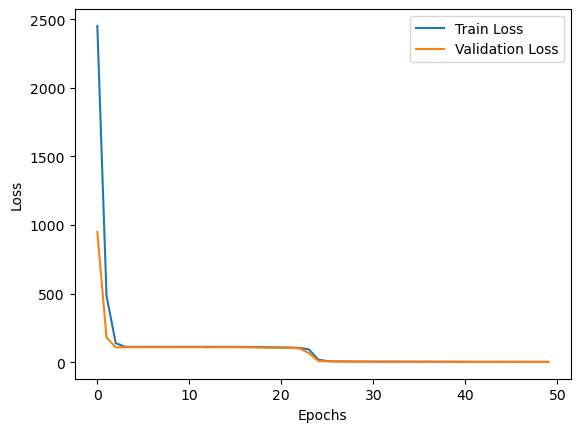

In [10]:
# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:

# Predict on the training data
predictions_train = model.predict(X_train)
# Print the first few predictions on training data
print("Predictions on Training Data:")
print(predictions_train[:5])

125/125 [==============================] - 2s 4ms/step
Predictions on Training Data:
[[ 65.01834 ]
 [105.765526]
 [ 65.75391 ]
 [ 78.510185]
 [ 82.85095 ]]


In [12]:
from sklearn.metrics import mean_squared_error

# Predict on the training data
predictions_train = model.predict(X_train)

# Predict on the test data
predictions_test = model.predict(X_test)

# Calculate RMSE for training data
rmse_train = np.sqrt(mean_squared_error(y_train, predictions_train))

# Calculate RMSE for test data
rmse_test = np.sqrt(mean_squared_error(y_test, predictions_test))

print(f"RMSE for Training Data: {rmse_train}")
print(f"RMSE for Test Data: {rmse_test}")


32/32 [==============================] - 1s 4ms/step
RMSE for Training Data: 1.359976877594817
RMSE for Test Data: 1.3509624942591867
